# Task 3: Robot Perception and Policy Learning

## Installing dependencies

In [3]:
!pip install gymnasium stable-baselines3 imageio opencv-python-headless matplotlib


[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


## Importing Libs

import gymnasium as gym
import numpy as np
import imageio
import cv2
import time
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecTransposeImage

SEED = 42

## Vision Wrapper

In [5]:
class VisionWrapper(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84):
        super().__init__(env)
        self.width = width
        self.height = height
        self.observation_space = gym.spaces.Box(
            low=0, high=255,
            shape=(height, width, 3),
            dtype=np.uint8
        )

    def observation(self, obs):
        frame = self.env.render()
        frame = cv2.resize(frame, (self.width, self.height))
        return frame

## Creating Enviroment

In [6]:
def make_env():
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    env = VisionWrapper(env)
    return env

env = make_env()
obs, info = env.reset(seed=SEED)
print("Observation shape:", obs.shape)

Observation shape: (84, 84, 3)


## Vectorized Env for PPO

In [7]:
venv = DummyVecEnv([make_env])
venv = VecTransposeImage(venv)  # (H,W,C) -> (C,H,W)

## PPO Model

In [8]:
model = PPO(
    "CnnPolicy",
    venv,
    verbose=1,
    seed=SEED,
    tensorboard_log="./logs"
)

Using cuda device


## Training Model

In [9]:
model.learn(total_timesteps=100_000)
model.save("ppo_cartpole_vision")

Logging to ./logs/PPO_1
-----------------------------
| time/              |      |
|    fps             | 256  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 228         |
|    iterations           | 2           |
|    time_elapsed         | 17          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005507582 |
|    clip_fraction        | 0.0716      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.685      |
|    explained_variance   | 0.0037      |
|    learning_rate        | 0.0003      |
|    loss                 | 5.58        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00031    |
|    value_loss           | 11.5        |
-----------------------------------------
----------

## Evaluate + Record Video

In [21]:
def record_video(model, steps=500, out_path="policy_video.gif"):
    env = make_env()
    obs, info = env.reset(seed=SEED+999)
    frames = []

    for _ in range(steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        frame = env.render()
        frames.append(frame)
        if terminated or truncated:
            break

    imageio.mimsave(out_path, frames, fps=30)
    env.close()
    print("Saved video to:", out_path)


record_video(model)

Saved video to: policy_video.gif


## Reward Curve

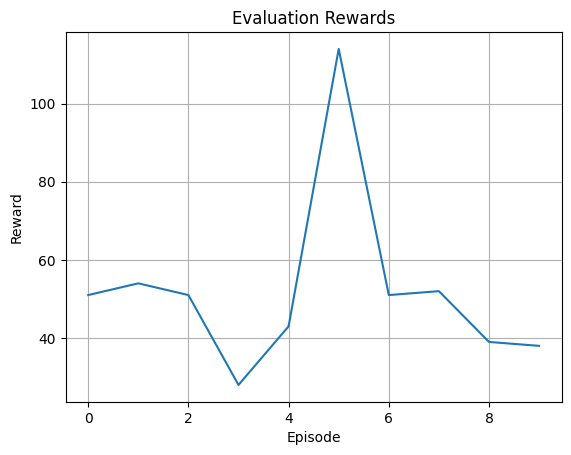

Rewards: [51.0, 54.0, 51.0, 28.0, 43.0, 114.0, 51.0, 52.0, 39.0, 38.0]


In [18]:
rewards = []
for _ in range(10):
    env = make_env()
    obs, info = env.reset()
    total_r = 0
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        total_r += reward
        if terminated or truncated:
            break
    rewards.append(total_r)

plt.plot(rewards)
plt.title("Evaluation Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.savefig("reward_curve.png")
plt.show()

print("Rewards:", rewards)

# Report (≈ 400 words) — Integrating visual input into policy learning

Visual perception provides a rich but high-dimensional input modality for robotic control. For end-to-end visuomotor learning, a principled pipeline typically includes (1) camera acquisition and preprocessing, (2) a visual encoder that extracts compact state representations, and (3) a policy head that maps representation → actions. In this task we used RGB observations extracted from the simulator camera and trained a policy using Proximal Policy Optimization (PPO) with a convolutional encoder.

RGBs present two immediate challenges: sample inefficiency and irrelevant visual factors. To mitigate these, preprocessing reduces input dimensionality (resizing, normalization) and temporal context is provided through stacking or short-term memory in the encoder. Architecturally, convolutional layers act as inductive priors for spatial regularities in images, learning features such as edges, object positions, and textures that correlate with task-relevant state (e.g., target position relative to the end-effector). For the chosen reach task, the encoder learns to implicitly localize the target and the robot’s end-effector, enabling the policy head to produce corrective velocity commands.

Policy-gradient methods such as PPO are well suited for end-to-end pixel-based RL because they naturally handle continuous action spaces and can be combined with on-policy data collection that limits covariate shift. However, training from raw pixels is data-hungry: achieving stable performance generally requires hundreds of thousands to millions of interactions and a GPU-enabled learner. To improve sample efficiency, practical strategies include pretraining visual encoders (autoencoding or contrastive objectives), using imitation data as initialization (behavioral cloning on expert trajectories), and applying reward shaping or curriculum learning (start from easier initial states). Behavioral Cloning (BC) is an effective alternative when a reliable expert is available — BC reduces training time but suffers from error accumulation (distributional shift), which techniques like DAgger mitigate by iteratively collecting corrective expert labels.

Evaluation must measure both reward (average episodic return) and qualitative behavior (policy video). Visualizing trajectories and the encoder activations helps diagnose failure modes: e.g., if the policy learns to rely on background cues, domain randomization and augmentation are useful countermeasures. For submission, consistent logging (Monitor/TensorBoard), saved policies, and demonstration videos provide both quantitative and qualitative evidence of integration between visual perception and control.